In [112]:
# Librerías
#!pip install --upgrade pandas
#!pip install geopandas
#!pip install xgboost
#!pip install lightgbm
#!pip install mlflow[extras]
#!pip install ipywidgets==7.7.5
import geopandas as gpd
import pandas as pd
import mlflow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Análisis Exploratorio de Datos

En esta primera parte se va a realizar un análisis exploratorio de los datos de forma general.

### Datos detallados del calendario para las publicaciones

A continuación se lee y se muestra la cabecera del `dataframe`que muestra los datos detallados del calendario para las publicaciones, y se inspecciona su estructura:

In [9]:
df_calendar = pd.read_csv('./dataset_nuevo/calendar.csv.gz', sep=',', parse_dates=['date'], index_col='listing_id')

# Renombra el nombre del índice
df_calendar.index.name = 'id'

df_calendar.head()

,date,available,price,adjusted_price,minimum_nights,maximum_nights
id,,,,,,
6369,2020-01-11,f,$80.00,$80.00,1.0,365.0
96072,2020-01-11,f,$25.00,$25.00,3.0,365.0
96072,2020-01-12,f,$25.00,$25.00,3.0,365.0
96072,2020-01-13,f,$25.00,$25.00,3.0,365.0
96072,2020-01-14,f,$25.00,$25.00,3.0,365.0


In [10]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7845708 entries, 6369 to 41281944
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           object        
 3   adjusted_price  object        
 4   minimum_nights  float64       
 5   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 419.0+ MB


Las columnas de `price` y `adjusted_price` tienen el símbolo del dólar. Se va a eliminar este símbolo (al igual que las comas) y a convertir las columnas en numéricas para trabajar con ellas con más facilidad.

In [11]:
df_calendar['price'] = df_calendar['price'].str.replace("$", '').str.replace(',','').astype('float64')
df_calendar['adjusted_price'] = df_calendar['adjusted_price'].str.replace("$", '').str.replace(',','').astype('float64')
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7845708 entries, 6369 to 41281944
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           float64       
 3   adjusted_price  float64       
 4   minimum_nights  float64       
 5   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 419.0+ MB


Ahora los tipos de datos son correctos. Se inspecciona si el `dataframe` tiene valores nulos:

In [12]:
df_calendar.isna().sum()

date                0
available           0
price             171
adjusted_price    171
minimum_nights      4
maximum_nights      4
dtype: int64

Como el `dataframe` tiene mucha información y muchas filas, se opta por eliminar las filas con valores nulos, ya que no creo que tengan un impacto negativo en el análisis exploratorio:

In [13]:
df_calendar.dropna(inplace=True)

Se va a proceder a obtener una descripción de las columnas numéricas de `df_calendar`. Se muestran los resultados de los cuantiles [0.25, 0.5, 0.75, 0.95, 0.99, 0.995]

In [14]:
# Solo columnas numéricas
df_calendar.describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99, 0.995], include=np.number)

,price,adjusted_price,minimum_nights,maximum_nights
count,7.845533e+06,7.845533e+06,7.845533e+06,7.845533e+06
mean,1.423431e+02,1.420381e+02,4.693651e+00,6.443547e+03
std,4.374274e+02,4.361963e+02,2.288716e+01,7.616210e+05
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+01,4.000000e+01,1.000000e+00,4.000000e+01
50%,7.000000e+01,7.000000e+01,2.000000e+00,1.125000e+03
75%,1.200000e+02,1.200000e+02,3.000000e+00,1.125000e+03
95%,4.140000e+02,4.140000e+02,1.200000e+01,1.125000e+03
99%,1.169000e+03,1.169000e+03,5.000000e+01,1.125000e+03
99.5%,1.500000e+03,1.500000e+03,9.000000e+01,1.125000e+03


Aquí se observa que el precio medio de los alquileres es de 142 dólares (con una desviación estándar de 437), lo que indica que hay una alta variabilidad de precios, y por tanto, una distribución anormal de los precios. Se aprecia omo aunque en el tercer cuartil los precios de los alquileres esté en 120 dólares, el cuantil 99 tiene un valor de 1169 dólares, por lo que hay un gran aumento de los precios a partir del tercer cuartil.

Podemos realizar una estimación de densidad de los precios para ver la distribución de los mismos:

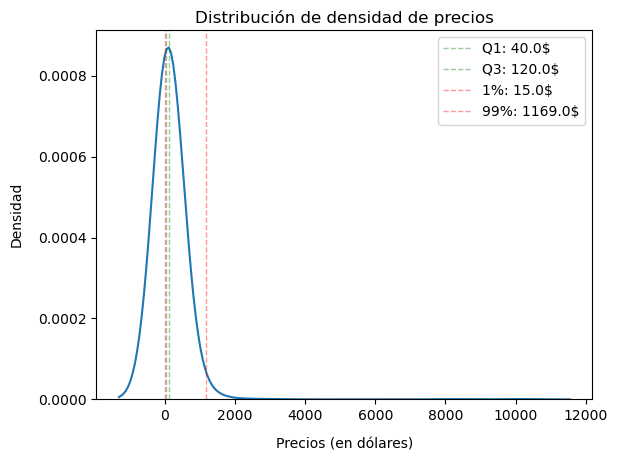

In [15]:
# Se establece la distribución de densidad de la columna 'price' y con 'bw' el ancho de banda de suavizado que se usa
ax = sns.kdeplot(data=df_calendar, x="price", bw_method=1)

# Línea vertical para mostrar donde está Q1, Q3, y los percentiles 1% y 99%
plt.axvline(x=np.percentile(df_calendar.price, 25), color='green', ls='--', lw=1, alpha=0.4, label='Q1: ' + 
            str(np.percentile(df_calendar.price, 25)) + '$')
plt.axvline(x=np.percentile(df_calendar.price, 75), color='green', ls='--', lw=1, alpha=0.4, label='Q3: ' +
            str(np.percentile(df_calendar.price, 75)) + '$')
plt.axvline(x=np.percentile(df_calendar.price, 1), color='red', ls='--', lw=1, alpha=0.4, label='1%: ' +
            str(np.percentile(df_calendar.price, 1)) + '$')
plt.axvline(x=np.percentile(df_calendar.price, 99), color='red', ls='--', lw=1, alpha=0.4, label='99%: ' +
            str(np.percentile(df_calendar.price, 99)) + '$')

# Se establece el título, los 'labels' de la gráfica y la leyenda
ax.set_title('Distribución de densidad de precios', pad=5, fontsize=12)
ax.set_xlabel('Precios (en dólares)', labelpad=10, fontsize=10)
ax.set_ylabel('Densidad', labelpad=10, fontsize=10)
plt.legend(loc='best')

En esta gráfica se aprecia que la mayoría de los precios está en torno al rango de los 40-120 dólares por día (primer y tercer cuartil). A precios menores o mayores a este rango, la densidad va disminuyendo, ya que la cantidad de alquileres a precios más bajos que Q1 o a precios más alto que Q3 es menor.

Se comprueban ahora las correlaciones numéricas de las columnas mediante el coeficiente de `Pearson`:

In [16]:
calendar_target = ['price', 'adjusted_price', 'minimum_nights', 'maximum_nights']

# Se muestra la correlación entre estas cuatro columnas y se colorea cada una de ellas según su importancia 
# con 'DataFrame.style.background_gradient()'
df_calendar[calendar_target].corr(method='pearson').style.background_gradient()

,price,adjusted_price,minimum_nights,maximum_nights
price,1.000000,0.999686,-0.013988,0.000004
adjusted_price,0.999686,1.000000,-0.013999,0.000009
minimum_nights,-0.013988,-0.013999,1.000000,-0.001103
maximum_nights,0.000004,0.000009,-0.001103,1.000000


Se aprecia una correlación positiva muy fuerte entre el precio y el precio ajustado, como se podía preveer al mostrar el `dataframe`. También vemos como no hay correlación ninguna entre los precios y los noches máximas o mínimas de alquiler.

Por último, para este dataframe creo que sería útil ver como evolucionan los precios a medida que pasan las fechas.

In [17]:
# Se lee de nuevo el dataframe especificando como índice la columna 'date' y quedándonos solamente con la columna 'price',
# eliminando los símbolos ',' y '$' como se ha realizado arriba
df_calendar_ts = pd.read_csv('./dataset_nuevo/calendar.csv.gz', sep=',', parse_dates=['date'], index_col='date')[['price']]
df_calendar_ts['price'] = df_calendar_ts['price'].str.replace("$", '').str.replace(',','').astype('float64')
df_calendar_ts.head()

,price
date,
2020-01-11,80.0
2020-01-11,25.0
2020-01-12,25.0
2020-01-13,25.0
2020-01-14,25.0


Si se agrupa el `dataframe` por fechas (días) y se realiza la media de los precios en cada una de ellas, se puede ver como evolucionan los precios cada día. El resultado sería una serie temporal con muchas variaciones. Para solucionar esto, se hace `downsampling` para tener una menor frecuencia (cada dos semanas en este caso):

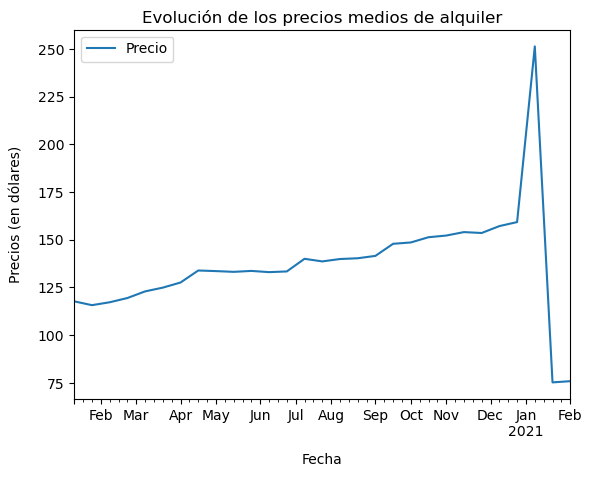

In [18]:
ax = df_calendar_ts.groupby('date').mean().resample(rule='2W').mean().plot()

# Se establece el título y los 'labels' de la gráfica
ax.set_title('Evolución de los precios medios de alquiler', pad=5, fontsize=12)
ax.set_xlabel('Fecha', labelpad=10, fontsize=10)
ax.set_ylabel('Precios (en dólares)', labelpad=10, fontsize=10)
plt.legend(["Precio"])

Como se puede apreciar, los precios han tenido a lo largo de 2020 una tendencia ascendente, con una fuerte subida en diciembre, en épocas navideñas y con ligeros repuntes en julio y septiembre. Con el comienzo del nuevo año y el fin de las épocas festivas, los precios cayeron a un mínimo global en torno a finales de enero de 2021.

### Resumen de información y métricas para las publicaciones

A continuación se lee y se muestra la cabecera del `dataframe` que muestra el resumen de información y métricas para las publicaciones y se inspecciona su estructura:

In [19]:
df_listing_summary = pd.read_csv('./dataset_nuevo/listings.csv', sep=',', index_col='id', parse_dates=['last_review'])
df_listing_summary.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45628,-3.67763,Private room,70,1,73,2019-12-13,0.61,1,82
21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40341,-3.74084,Private room,17,4,33,2018-07-15,0.52,2,162
23001,Apartmento Arganzuela- Madrid Rio,82175,Jesus,Arganzuela,Legazpi,40.38695,-3.69304,Entire home/apt,50,15,0,NaT,NaN,6,213
24805,Gran Via Studio Madrid,101471,Iraido,Centro,Universidad,40.42202,-3.70395,Entire home/apt,80,5,9,2020-01-03,0.14,1,362
24836,"Select the Madrid more ""cool"".",101653,Tenty,Centro,Justicia,40.41995,-3.69764,Entire home/apt,115,3,67,2019-12-08,0.64,1,342


In [20]:
df_listing_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21495 entries, 6369 to 41452557
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            21492 non-null  object        
 1   host_id                         21495 non-null  int64         
 2   host_name                       21470 non-null  object        
 3   neighbourhood_group             21495 non-null  object        
 4   neighbourhood                   21495 non-null  object        
 5   latitude                        21495 non-null  float64       
 6   longitude                       21495 non-null  float64       
 7   room_type                       21495 non-null  object        
 8   price                           21495 non-null  int64         
 9   minimum_nights                  21495 non-null  int64         
 10  number_of_reviews               21495 non-null  int64         
 11  l

Todas las columnas tienen correctamente su tipo establecido. Se pasa a mostrar la correlación entre todas las variables numéricas:

In [21]:
target = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month',
         'calculated_host_listings_count', 'availability_365']

# Se muestra la correlación entre estas cuatro columnas y se colorea cada una de ellas según su importancia 
# con 'DataFrame.style.background_gradient()'
df_listing_summary[target].corr(method='pearson').style.background_gradient()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.246657,0.037647,0.004586,-0.049415,-0.061073,-0.028985,-0.000796,0.001133
longitude,0.246657,1.000000,0.051922,-0.016257,-0.054029,-0.089331,0.023903,-0.054008,-0.000624
price,0.037647,0.051922,1.000000,-0.014658,-0.074793,-0.161354,-0.041010,0.057652,0.061795
minimum_nights,0.004586,-0.016257,-0.014658,1.000000,-0.043536,-0.045839,-0.069528,-0.022443,0.029423
number_of_reviews,-0.049415,-0.054029,-0.074793,-0.043536,1.000000,0.288836,0.659177,-0.062933,0.044483
last_review,-0.061073,-0.089331,-0.161354,-0.045839,0.288836,1.000000,0.386139,0.009144,0.017389
reviews_per_month,-0.028985,0.023903,-0.041010,-0.069528,0.659177,0.386139,1.000000,-0.105144,0.018325
calculated_host_listings_count,-0.000796,-0.054008,0.057652,-0.022443,-0.062933,0.009144,-0.105144,1.000000,0.174474
availability_365,0.001133,-0.000624,0.061795,0.029423,0.044483,0.017389,0.018325,0.174474,1.000000


Se puede ver como hay una correlación positiva alta entre el número de `reviews` y las `reviews` por mes. También hay correlación positiva entre la última reseña y las resñas por mes, y entre la última reseña y el número de `reviews`realizadas. Por otro lado, se puede ver que hay cierta correlación positiva entre la longitud y la latitud. En cuánto al precio, no parece que haya ninguna variable numérica que influya en ella positiva o negativamente de forma significativa. <br>

Ahora nos centramos en los distritos de la ciudad, y es que en este `dataframe` aparece información sobre los distritos de Madrid. Primero vemos el número de alquileres que hay por distrito:

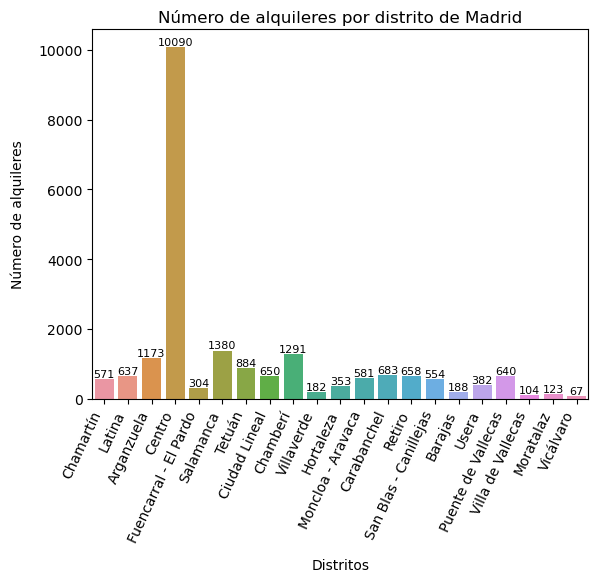

In [22]:
df_listing_summary['neighbourhood_group'].value_counts()

# Cuenta de observaciones
ax = sns.countplot(data=df_listing_summary, x='neighbourhood_group')

# Se muestra la cuenta arriba de cada barra
ax.bar_label(ax.containers[0], fontsize=8)

# Se establece el título, los 'ticks' en el eje X y los 'labels' de la gráfica
plt.title('Número de alquileres por distrito de Madrid', pad=5, fontsize=12)
plt.xlabel('Distritos', labelpad=10, fontsize=10)
plt.ylabel('Número de alquileres', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');

Centro, Salamanca, Chamberí y Arganzuela son los distritos donde más alquileres hay (principalmente en Centro, donde hay más de 10000 alquileres). Por el contrario, en Vicálvaro, Villa de Vallecas o Moratalaz son los distritos donde menos alquileres hay (menos de 150 alquileres en todos estos distritos).

Para profundizar más en este aspecto, se realiza un diagrama de cajas para ver como se distribuye el precio en cada uno de estos distritos (sin valores atípicos, para ver la gráfica con más claridad):

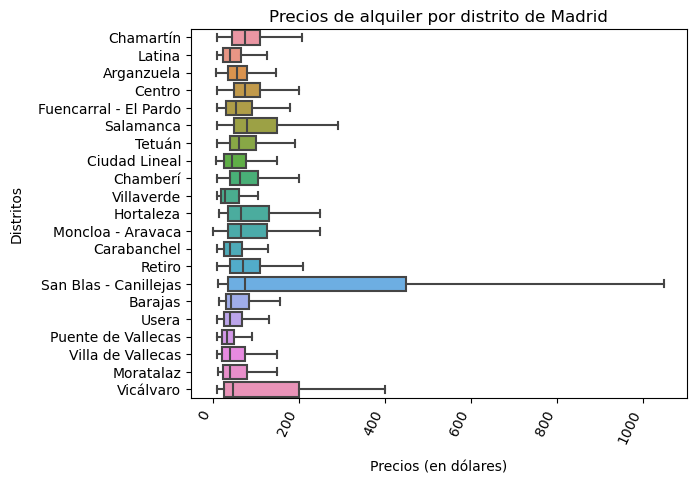

In [23]:
# Diagrama de cajas sin outliers (showfliers es False)
sns.boxplot(data=df_listing_summary, x='price', y='neighbourhood_group', showfliers=False)

# Se establece el título, los 'ticks' en el eje X y los 'labels' de la gráfica
plt.title('Precios de alquiler por distrito de Madrid', pad=5, fontsize=12)
plt.xlabel('Precios (en dólares)', labelpad=10, fontsize=10)
plt.ylabel('Distritos', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');

Como se puede ver en el diagrama de cajas, según las medianas los precios más altos están en distritos como los de San Blas - Canillejas, Salamanca o Chamartín. En cambio, los más bajos están en distritos como Carabanchel, Villaverde o Puente de Vallecas. <br>
Por otra parte, se aprecia claramente que el precio máximo de alquiler (sin valores atípicos) está en el distrito de San Blas - Canillejas, con un precio de más de 1000 dólares. <br>
Por último, hay que destacar los rangos intercuartílicos del propio distrito de San Blas - Canillejas y del distrito de Vicálvaro. Son rangos muy grandes, lo que hace indicar que la variabilidad de precios en esos distritos es muy alta.

También puede ser interesante ver la distribución de los precios en cada uno de los tipos de habitaciones ofertados. Ya que dependiendo del tipo de habitación que se quiere alquilar, ésta se puede poner en alquiler a mayor o menor precio. Para verlo gráficamente realizamos un diagrama de violines: 

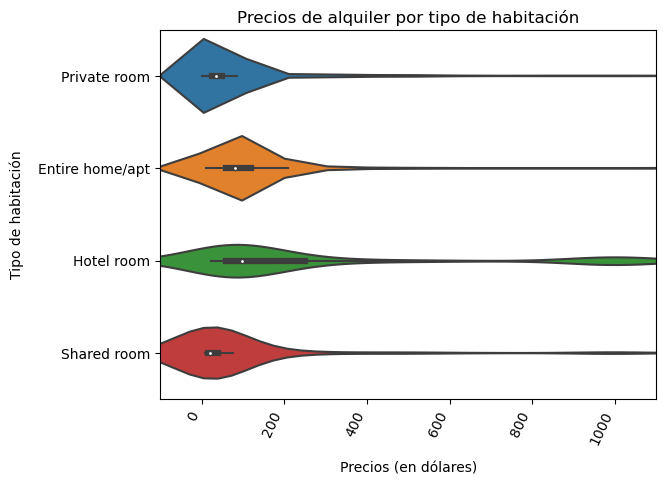

In [24]:
# Diagrama de violines (limitando el eje X para ver mejor la gráfica)
ax = sns.violinplot(data=df_listing_summary, x='price', y='room_type', inner='box')
ax.set(xlim=(-100, 1100))

# Se establece el título, los 'ticks' en el eje X y los 'labels' de la gráfica
plt.title('Precios de alquiler por tipo de habitación', pad=5, fontsize=12)
plt.xlabel('Precios (en dólares)', labelpad=10, fontsize=10)
plt.ylabel('Tipo de habitación', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');

En esta ocasión se puede ver como los precios más caros son de habitaciones de hoteles y de casas/apartamentos enteros, mientras que los precios más bajos son de habitaciones privadas y habitaciones compartidas. <br>
También se aprecia como la mayor variabilidad de precios se da en habitaciones de hotel, ya que su rango intercuartílico es el mayor de todos.

Otro análisis interesante para ver como se encuentra actualmente el mercado de alquileres en Madrid, sería ver una distribución del tipo de alquileres según el distrito en el que nos encontremos.

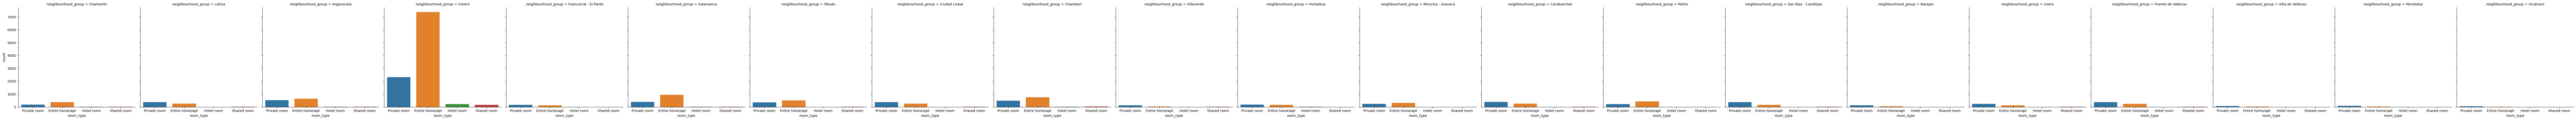

In [25]:
sns.catplot(data=df_listing_summary, x='room_type', col = 'neighbourhood_group', kind='count')

De forma general, lo que más se ofrece son casas/apartamentos completos o habitaciones privadas. En la mayoría de ellos, la mayor oferta es de casas/apartamentos completos. Solo hay unos pocos distritos donde se ofrecen mayor cantidad de habitaciones privadas que apartamentos enteros, como en Latina, El Pardo, Ciudad Lineal, Carabanchel o Moratalaz. 
Las habitaciones de hotel y las habitaciones compartidas realmente tienen poquísimas ofertas en todo Madrid.

También hay disponibles en el `dataframe` datos sobre la longitud y la latitud de los alquileres. Sería interesante ver un gráfico de dispersión de estas dos variables según el distrito al que pertenecen para ver si latitudes y longitudes parecidas pertenecen al mismo distrito:

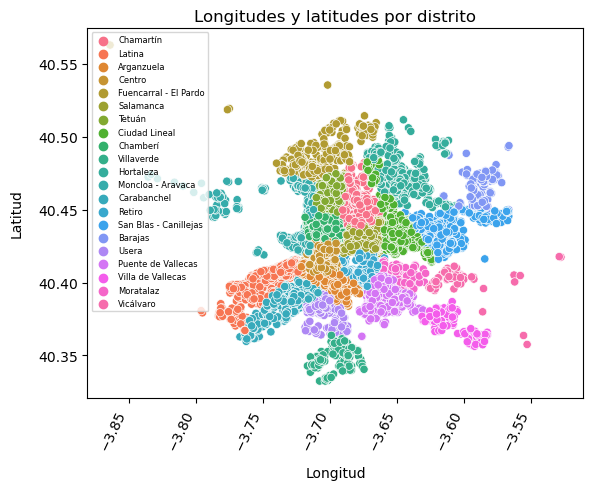

In [26]:
# Diagrama de dispersión
ax = sns.scatterplot(data=df_listing_summary, x="longitude", y="latitude", hue="neighbourhood_group")

# Se establece el título. los 'ticks' en el eje X, los 'labels' y la leyenda de la gráfica (reduciendo su tamaño)
plt.title('Longitudes y latitudes por distrito', pad=5, fontsize=12)
plt.xlabel('Longitud', labelpad=10, fontsize=10)
plt.ylabel('Latitud', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');
plt.legend(handles=ax.get_legend_handles_labels()[0],
           fontsize="6",
           loc='best')

Efectivamente, longitudes y latitudes cercanas pertenecen al mismo distrito. Esto tiene sentido, ya que, evidentemente, dependiendo de la localización geográfica tendremos unas longitudes y latitudes distintos, y por cada distrito, estas longitudes y latitudes deben ser muy parecidas o próximas entre ellas.

Se puede hacer otro gráfico de dispersión con la longitud y la latitud, pero esta vez agrupando por la disponibilidad de los alquileres al día durante un periodo anual:

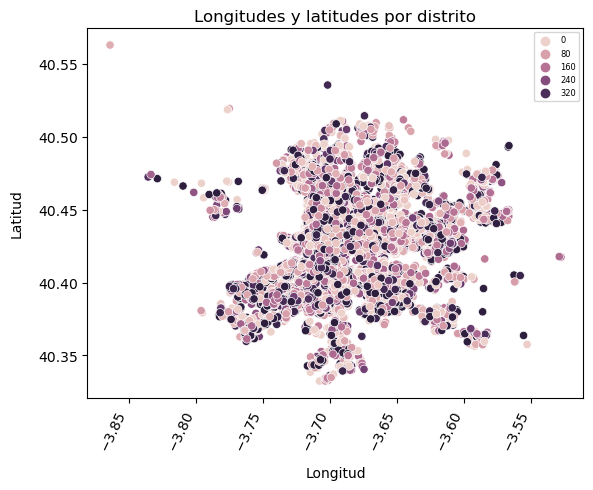

In [27]:
# Diagrama de dispersión
ax = sns.scatterplot(data=df_listing_summary, x="longitude", y="latitude", hue="availability_365")

# Se establece el título. los 'ticks' en el eje X, los 'labels' y la leyenda de la gráfica (reduciendo su tamaño)
plt.title('Longitudes y latitudes por distrito', pad=5, fontsize=12)
plt.xlabel('Longitud', labelpad=10, fontsize=10)
plt.ylabel('Latitud', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');
plt.legend(handles=ax.get_legend_handles_labels()[0],
           fontsize="6",
           loc='best')

Se aprecia que no hay correlación entre las variables de longitud y latitud y la disponibilidad anual de los alquileres. Los puntos de varios colores se reparten a lo largo de todo el gráfico, por lo que la disponibilidad de los alquileres es muy diversa, pero se reparte por todas las longitudes y latitudes de la ciudad de Madrid.

Ahora se va a analizar de forma general las reseñas realizadas en `Airbnb`. Una gráfica interesante sería ver las reseñas por mes que se han realizado por distrito, ya que en los distritos donde mayor ratio de reseñas se realiza nos indicaría que muy probablemente habrá más huéspedes que se hospenden por esas zobnas:

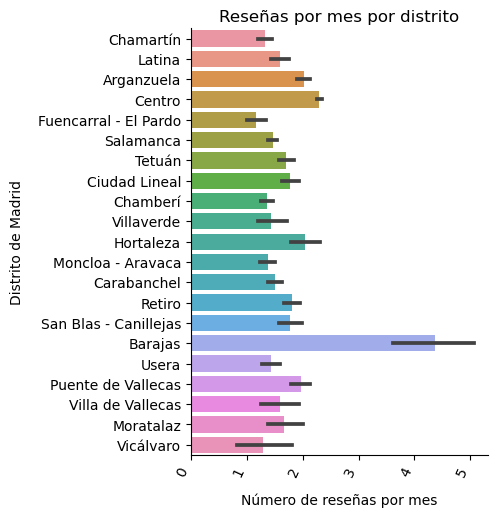

In [28]:
# Diagrama de barras
sns.catplot(data=df_listing_summary, x='reviews_per_month', y='neighbourhood_group', kind='bar')

# Se establece el título. los 'ticks' en el eje X y los 'labels' de la gráfica
plt.title('Reseñas por mes por distrito', pad=5, fontsize=12)
plt.xlabel('Número de reseñas por mes', labelpad=10, fontsize=10)
plt.ylabel('Distrito de Madrid', labelpad=10, fontsize=10)
plt.xticks(rotation = 65, ha='right');

En el distrito de Barajas es dónde más reseñas por mes de media se realizan con bastante diferencia (más de 4 reseñas por mes) a pesar de que se ha visto anteriormente que es uno de los distritos donde menos alquileres ofertados hay. Esto indica que los huéspedes que se hospedan en este distrito es muy probable que escriban alguna reseña. Les siguen en este sentido distritos como Centro (el que más oferta de alquileres tiene) y Arganzuela, con más de 2 reseñas de media por mes. <br>
Por el lado contrario, tenemos distritos como Vicálvaro y Fuencarral - El Pardo, con menos de dos reseñas por mes.

Ahora pasamos a analizar los datos geoespaciales. Para empezar, se va a realizar un mapa coroplético que muestre el precio medio del alquiler en cada uno de los barrios de Madrid, así se tiene una idea de a cuánto puede estar el precio medio de alquiler por barrios:

<Axes: >

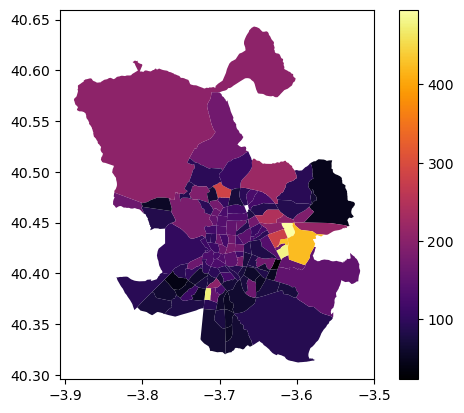

In [29]:
# Archivo GeoJSON con todos los barrios de Madrid
geojson = gpd.read_file('./dataset_nuevo/neighbourhoods.geojson')

# Se fusiona el archivo GeoJSON con las dos columnas de 'df_listing_summary', agrupando el GeoDataframe
# por barrio, calculando la media de los precios. Por último se dibuja el mapa coroplético
geojson.merge(df_listing_summary[['price', 'neighbourhood']], on = 'neighbourhood') \
                .dissolve(by='neighbourhood', aggfunc={"price": "mean"}) \
                .plot('price', cmap = 'inferno', legend=True)

La información mostrada aquí muestra que los precios de alquiler medios más caros están en barrios como Canillejas, Arcos o Zofío, dónde se llegan a alcanzar los 400 dólares. Por otro lado, los precios medios más baratos se encuentran en barrios como Horcajo, Aluche o Vista Alegre, lugares dónde el alquiler medio está por debajo de los 100 dólares.

Ahora se procede a realizar lo mismo, pero esta vez con los distritos de Madrid. El resultado es el siguiente:

<Axes: >

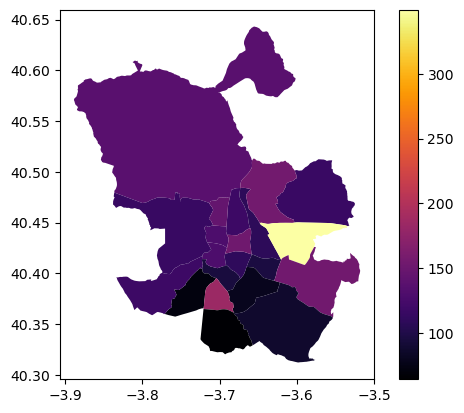

In [30]:
# Se fusiona el archivo GeoJSON con las dos columnas de 'df_listing_summary', agrupando el GeoDataframe
# por distrito, calculando la media de los precios. Por último se dibuja el mapa coroplético
geojson.merge(df_listing_summary[['price', 'neighbourhood_group']], on = 'neighbourhood_group') \
                .dissolve(by='neighbourhood_group', aggfunc={"price": "mean"}) \
                .plot('price', cmap = 'inferno', legend=True)

Como se puede apreciar, el precio medio más alto está en el distrito de San Blas - Canilleja, que está en torno a los 340 dólares. Por el contrario, los precios más bajos se encuentran en distritos como Villaverde o Carabanchel, dónde los alquileres están por debajo de los 100 dólares. <br>
Como se puede comprobar, la información obtenida en este mapa se parece bastante a la obtenida en el diagrama de cajas realizado anteriormente en los distritos de Madrid.

# Predicción

#### Importante: Se ha reducido el `dataset` a un 5% de los registros originales, ya que el coste computacional de los entrenamientos y registros de los modelos en MLflow era muy alto trabajando en local. Esto ha hecho reducir las métricas mucho respecto a antes.

En esta parte del `notebook` se va a intentar entrenar un modelo que sea capaz de predecir el precio de alquiler diario de una propiedad de `Airbnb`.

In [31]:
df_listing = pd.read_csv('./dataset_nuevo/listings.csv.gz', sep=',', index_col='id', low_memory=False)

Las columna objetiva price tiene el símbolo del dólar. Además también hay otras columnas monetarias con el mismo problema. Por lo tanto, se va a eliminar este símbolo (al igual que las comas) y a convertir las columnas en numéricas para trabajar con ellas con más facilidad.

In [32]:
df_listing['price'] = df_listing['price'].str.replace("$", '').str.replace(',','').astype('float64')
df_listing['cleaning_fee'] = df_listing['cleaning_fee'].str.replace("$", '').str.replace(',','').astype('float64')
df_listing['security_deposit'] = df_listing['security_deposit'].str.replace("$", '').str.replace(',','').astype('float64')
df_listing['extra_people'] = df_listing['extra_people'].str.replace("$", '').str.replace(',','').astype('float64')
df_listing['monthly_price'] = df_listing['monthly_price'].str.replace("$", '').str.replace(',','').astype('float64')
df_listing['weekly_price'] = df_listing['weekly_price'].str.replace("$", '').str.replace(',','').astype('float64')

Este `dataframe` contiene demasiadas columnas. Se comprueba con el coeficiente de Pearson las variables numéricas que más pueden influir en el precio para correlaciones positivas (obviamente sin incluir las variable de precio):

In [33]:
df_listing.corr(numeric_only=True, method='pearson')['price'].nlargest(n=21)[3:]

square_feet                                     0.312792
accommodates                                    0.105941
cleaning_fee                                    0.098121
beds                                            0.094738
availability_30                                 0.093308
bedrooms                                        0.092216
availability_60                                 0.083132
availability_90                                 0.076761
host_id                                         0.068562
availability_365                                0.061795
security_deposit                                0.061578
calculated_host_listings_count                  0.057652
longitude                                       0.051922
calculated_host_listings_count_entire_homes     0.051521
calculated_host_listings_count_private_rooms    0.042715
latitude                                        0.037647
bathrooms                                       0.033799
guests_included                

Del mismo modo, se comprueba con el coeficiente de Pearson las variables numéricas que más pueden influir en el precio para correlaciones negativas:

In [34]:
df_listing.corr(numeric_only=True, method='pearson')['price'].nsmallest(n=10)

number_of_reviews_ltm                         -0.081587
number_of_reviews                             -0.074793
reviews_per_month                             -0.041010
calculated_host_listings_count_shared_rooms   -0.016677
review_scores_communication                   -0.016062
maximum_minimum_nights                        -0.015253
minimum_nights_avg_ntm                        -0.015085
minimum_nights                                -0.014658
review_scores_rating                          -0.013410
review_scores_checkin                         -0.013254
Name: price, dtype: float64

Como se puede apreciar, no hay muchas variables que tengan gran correlación con el precio de una casa:
* Dentro de las correlaciones positivas variables, hay algunas que se deben eliminar, pues el cliente parte de una situación de partida a la hora de alquilar viviendas. Por tanto, se eliminará `host_id`, ya que es el identificador de los anfitriones de los alquileres; y las demás variables de `host`, ya que al principio no se tendría esa información.
* En las correlaciones negativas, las variables de `reviews` no se pueden incluir puesto que al principio el cliente no tiene información de reseñas acerca de su casa. En cuánto a las demás variables, la correlación es pequeñisima, y por tanto, no se incluyen en la selección de características finales.

Se guardan los nombres de las variables numéricas elegidas en un `array`:

In [35]:
# Por cada variable de las correlaciones más altas, guarda las que no tengan el string 'host'
numerical_columns = [variable for variable in df_listing.corr(numeric_only=True, method='pearson')['price'].nlargest(n=21)[3:].index 
                     if 'host' not in variable]
numerical_columns

['square_feet',
 'accommodates',
 'cleaning_fee',
 'beds',
 'availability_30',
 'bedrooms',
 'availability_60',
 'availability_90',
 'availability_365',
 'security_deposit',
 'longitude',
 'latitude',
 'bathrooms',
 'guests_included']

Una vez analizaas las columnas numéricas, se imprime en una lista las variables no numéricas para ver cuáles se tienen:

In [36]:
# Columnas con variables no numéricas
df_listing.select_dtypes(exclude=np.number).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license', 'license',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_p

Aquí se eliminan columnas con `URL`, ya que no aportan información; las de ciudad (todo es Madrid); código postal, país, ya que no aportan información o ésta es redundante; y las de `host`, reseñas, o calendarios, ya que no tendríamos esa información al principio para los nuevos alquileres. Por lo tanto, se eligen las columnas de tipos de propiedad, barrios, distritos, comodidades, que ya se han visto en el análisis exploratorio de datos que pueden ser útiles para predecir el precio de alquileres, y la variable objetivo `price`. <br>
Al final, el dataframe resultante con las columnas elegidas (numéricas y categóricas) sería el siguiente:

In [37]:
df_listing_reduced = df_listing[numerical_columns + ['neighbourhood', 'neighbourhood_group_cleansed', 
                                                     'property_type', 'room_type', 'amenities', 'price']]

Se muestra el nuevo `dataframe` por pantalla:

In [38]:
df_listing_reduced.head()

,square_feet,accommodates,cleaning_fee,beds,availability_30,bedrooms,availability_60,availability_90,availability_365,security_deposit,longitude,latitude,bathrooms,guests_included,neighbourhood,neighbourhood_group_cleansed,property_type,room_type,amenities,price
id,,,,,,,,,,,,,,,,,,,,
6369,172.0,2,5.0,0.0,22,1.0,52,82,82,0.0,-3.67763,40.45628,1.0,2,Chamartín,Chamartín,Apartment,Private room,"{Wifi,""Air conditioning"",Kitchen,Elevator,Heat...",70.0
21853,97.0,1,NaN,1.0,0,1.0,0,0,162,NaN,-3.74084,40.40341,1.0,1,Aluche,Latina,Apartment,Private room,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",17.0
23001,1184.0,6,30.0,5.0,2,3.0,2,2,213,300.0,-3.69304,40.38695,2.0,1,Legazpi,Arganzuela,Apartment,Entire home/apt,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",50.0
24805,0.0,3,30.0,1.0,27,0.0,57,87,362,200.0,-3.70395,40.42202,1.0,2,Malasaña,Centro,Apartment,Entire home/apt,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",80.0
24836,NaN,4,0.0,3.0,24,2.0,54,77,342,200.0,-3.69764,40.41995,1.5,4,Justicia,Centro,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",115.0


Una vez elegidas las columnas, se van a repartir por un lado las columnas numéricas, guardándolas en una variable; y por otro lado las columnas categóricas, guardándolas en otra variable:

In [39]:
# Variables categóricas (excluye tipos np.number)
categorical_df_columns = df_listing_reduced.select_dtypes(exclude=np.number).columns

# Variables numéricas (incluye tipos np.number)
numerical_df_columns = df_listing_reduced.select_dtypes(include=np.number).columns

print('Categóricas: ', categorical_df_columns)
print('\nNuméricas: ', numerical_df_columns)

Categóricas:  Index(['neighbourhood', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'amenities'],
      dtype='object')

Numéricas:  Index(['square_feet', 'accommodates', 'cleaning_fee', 'beds',
       'availability_30', 'bedrooms', 'availability_60', 'availability_90',
       'availability_365', 'security_deposit', 'longitude', 'latitude',
       'bathrooms', 'guests_included', 'price'],
      dtype='object')


En relación a las columnas categóricas hay que tener en cuenta dos aspectos: el número de valores que puede tomar cada una; y si existe una relación de orden entre estos valores. Estos factores determinan el tipo de transformación que se ha de hacer:

* Si la columna tiene dos valores se puede binarizar directamente.
* Si por el contrario, tiene más de dos valores sin un orden entre ellos, se aplica la técnica `One Hot Encoding`, la cual crea una columna binaria para cada uno de dichos valores.
* Si la columna categórica tiene una relación de orden, los valores se transforman a numéricos, sustituyendo cada valor por su orden.

A continuación, se obtiene el número de valores para cada una de las variables categóricas:

In [40]:
# Se imprime el nombre y el número de valores para cada columna de la lista de variables categóricas
num_values_categ_df_col = list(map(lambda col: (col, len(df_listing_reduced[col].value_counts())), categorical_df_columns))
num_values_categ_df_col

[('neighbourhood', 67),
 ('neighbourhood_group_cleansed', 21),
 ('property_type', 31),
 ('room_type', 4),
 ('amenities', 19182)]

Como se puede ver, las columnas categóricas tienen todas más de dos valores, y además, no tienen ningún orden entre ellos. Por tanto, se debe aplicar la técnica de `One Hot Encoding` a todas ellas para crear una columna binaria para cada uno de los valores que pueden presentar estas columnas. <br>
Sin embargo, hay una columna que realmente debe tratarse distinta, y esta columna es `amenities`, ya que tiene una grandísima cantidad de valores.

Como se ha podido ver en el `dataframe`, la columna `amenities` es un conjunto con todas las comodidades de cada alquiler. Para transformar esta variable se puede usar `MultiLabelBinarizer`, pero suceden dos cosas: me da problemas al insertarlo posteriormente en los `pipelines` posteriores; y segundo, se crearían demasiadas columna, ya que se crearía una para cada una de las palabras únicas que aparecen en toda la columna (por lo que se crearían más de 150 columnas binarias). Debido a estos dos motivos, se decide sustituir cada conjunto de la columna por un número entero que simbolice el número de comodides totales que tiene cada alquiler.

Para ello se eliminan los símbolos `{` y `}` de cada conjunto, y se convierte a una lista. Una vez construida la lista para cada fila, se eliminan los elementos que contienen el `substring` 'translation', ya que no se trata de comodidades y se calcula finalmente el número de elementos de la lista.

In [41]:
# Reemplazo de valores y conversión a lista cada fila de la columna 'amenities'
df_listing_reduced.loc[:, 'amenities'] = df_listing_reduced['amenities'].str.replace("{", "") \
                        .str.replace("}", "") \
                        .str.replace('"', "") \
                        .str.split(',')

# Para cada fila de la columna 'amenities' se aplica una función: de la lista de comodidades, se eliminan las
# que tengan el subtring 'translation' porque estos elementos de la lista no son comodidades
df_listing_reduced.loc[:, 'amenities'] = df_listing_reduced['amenities'].apply(lambda x: [element for element in x if 'translation' not in element])

# Para cada fila de la columna 'amenities', se cuenta el número total de comodidades
df_listing_reduced.loc[:, 'amenities'] = df_listing_reduced['amenities'].apply(lambda x: len(x))

Una vez se han seleccionado las columnas y se ha transformado la columna `amenities`, se imprime por pantalla la información sobre cada tipo de las columnas del `dataframe`:

In [42]:
df_listing_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21495 entries, 6369 to 41452557
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   square_feet                   301 non-null    float64
 1   accommodates                  21495 non-null  int64  
 2   cleaning_fee                  16270 non-null  float64
 3   beds                          21356 non-null  float64
 4   availability_30               21495 non-null  int64  
 5   bedrooms                      21479 non-null  float64
 6   availability_60               21495 non-null  int64  
 7   availability_90               21495 non-null  int64  
 8   availability_365              21495 non-null  int64  
 9   security_deposit              14440 non-null  float64
 10  longitude                     21495 non-null  float64
 11  latitude                      21495 non-null  float64
 12  bathrooms                     21480 non-null  float64
 13  

Como se ve en la tabla, prácticamente todas las columnas tienen el tipo correcto. Solo habría que cambiar el tipo de la variable `amenities`, que tras las transformaciones realizadas arribas, ya no es una variable de tipo objeto, sino una variable de tipo entero:

In [43]:
df_listing_reduced = df_listing_reduced.astype({'amenities': np.int64})

Una vez transformado al tipo adecuado, se elimina la variable `amenities` de la lista de variables categóricas:

In [44]:
# Se elimina la columna 'amenities' de la lista de variables categóricas
categorical_columns = categorical_df_columns.to_list()
categorical_columns.remove('amenities')
categorical_columns

['neighbourhood', 'neighbourhood_group_cleansed', 'property_type', 'room_type']

Y se une a la lista de variables numéricas:

In [45]:
# Se añade la columna 'amenities' a la lista de variables numéricas
numerical_columns = numerical_df_columns.to_list()
numerical_columns.append('amenities')
numerical_columns

['square_feet',
 'accommodates',
 'cleaning_fee',
 'beds',
 'availability_30',
 'bedrooms',
 'availability_60',
 'availability_90',
 'availability_365',
 'security_deposit',
 'longitude',
 'latitude',
 'bathrooms',
 'guests_included',
 'price',
 'amenities']

Ahora que ya se ha tratado esta columna aparte, a las demás variables categóricas se les aplica la técnica `One Hot Encoding` como se ha comentado anteriormente. Para ello se crea un `pipeline` (una secuencia de transformaciones de datos) para que de esta forma los datos puedan ser procesados posteriormente en el modelo durante el proceso de entrenamiento. <br>
Así, para este `pipeline`se van a definir dos pasos:
* Un objeto `SimpleImputer` (que reemplace los valores perdidos por la etiqueta `missing`)
* Un objeto `OneHotEncoder` que transforme las variables categóricas a etiquetas binarias. Se fija el parámetro `handle_unknown='ignore'` para que si encuentrora alguna categoría desconocida después del entrenamiento, las columnas resultantes sean todas cero.

In [46]:
# Se crea un 'pipeline' para variables categóricas que imputa valores perdidos usando el valor 'missing' y 
# que realiza 'One Hot Encoding', creando una columna binaria para cada uno de los valores que puede tomar cada variable
# El 'pipeline' es una lista de tuplas (nombre, transformación)
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', 
                                                              fill_value='missing')), 
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
categorical_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Una vez definido el `pipeline`que se va a usar para las variables categóricas, se pasa a inspeccionar las variables numéricas. Para empezar, se comprueba si hay valores perdidos en cada una de ellas, y el número de ellas:

In [47]:
df_listing_reduced[numerical_columns].isna().sum()

square_feet         21194
accommodates            0
cleaning_fee         5225
beds                  139
availability_30         0
bedrooms               16
availability_60         0
availability_90         0
availability_365        0
security_deposit     7055
longitude               0
latitude                0
bathrooms              15
guests_included         0
price                   0
amenities               0
dtype: int64

Puede apreciarse que hay muchísimos valores perdidos en `square_feet`, además de `security_deposit` y `cleaning_fee`. En menor medida, hay valores perdidos en `beds`, `bedrooms` y `bathrooms`. Esto hay que tratarlo de alguna forma.

Por otra parte, las variables numéricas de longitud y latitud, las cuales están expresadas en grados, tienen el problema de que representan un espacio tridimensional. Esto significa que los dos valores más extremos de la coordenada de longitud en la realidad están muy cerca uno de otro. Lo que se puede realizar para intentar solucionar esto es mapear estas dos coordenadas a coordenadas cartesianas (X, Y y Z). De esta forma, los puntos cercanos en estas tres dimensiones serán también puntos cercanos en la realidad. <br>
Así, se crean tres nuevas columnas para estas tres coordenadas y se eliminan las columnas de `latitude` y `longitude`: 

In [48]:
# Se crean las tres nuevas columnas (importante asignarlas al dataframe existente)
df_listing_reduced = df_listing_reduced.assign(X = 6378137 * np.cos(np.radians(df_listing_reduced['latitude'])) * np.cos(np.radians(df_listing_reduced['longitude'])))
df_listing_reduced = df_listing_reduced.assign(Y = 6378137 * np.cos(np.radians(df_listing_reduced['latitude'])) * np.sin(np.radians(df_listing_reduced['longitude'])))
df_listing_reduced = df_listing_reduced.assign(Z = 6378137 * np.sin(np.radians(df_listing_reduced['latitude'])))

# Se eliminan las columnas de longitud y latitud
df_listing_reduced = df_listing_reduced.drop(columns=['latitude', 'longitude'])

Una vez se tienen estas tres nuevas columnas, se añaden a la lista de columnas numéricas y se eliminan las columnas de latitud y longitud. Además, se elimina la variable `price`, ya que esta va a ser la etiqueta o variable objetivo:

In [49]:
# List Comprehensión para eliminar las dos variables de la lista, además de la variable objetivo 'price'
numerical_columns = [column for column in numerical_columns if 'latitude' not in column if 'longitude' not in column
                    if 'price' not in column]

# Se extiende la lista con las nuevas columnas de las coordenadas cartesianas
numerical_columns.extend(['X', 'Y', 'Z'])

# Imprimer lista por pantalla para ver que está correcta
numerical_columns

['square_feet',
 'accommodates',
 'cleaning_fee',
 'beds',
 'availability_30',
 'bedrooms',
 'availability_60',
 'availability_90',
 'availability_365',
 'security_deposit',
 'bathrooms',
 'guests_included',
 'amenities',
 'X',
 'Y',
 'Z']

Una vez creadas las nuevas columnas, se crea un `pipeline` que será utilizado posteriormente para las características numéricas. En este caso, también se va a definir un `pipeline` de dos pasos:
* En el primero de ellos se imputan valores perdidos (de nuevo con `SimpleImputer`), con la media o mediana de cada columna (se definirá la estrategia más adelante).
* En el segunda se usa `Standard Scaler` para escalar y redimensionar la distribución de los valores de cada columna, de forma que al final tengan media cero y desviación típica unidad. Así, ningun valor individual de ninguna columna influye desproporcionadamente en el algoritmo debido a diferencias de escala.

In [50]:
# Se crea un 'pipeline' para variables numéricas que imputa valores 
# perdidos y que escala los valores a media cero y desviación unidad 
# El 'pipeline' es una lista de tuplas (nombre, transformación)
numerical_transformer = Pipeline([('imputer', SimpleImputer()), 
                                  ('scaler', StandardScaler())])
numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

Antes del entrenamiento, falta realizar una última cosa. Y es que puede fusionar `df_listing_reduced` con `df_calendar`, el cual se examinó en el apartado del análisis exploratorio de datos. De esta forma, sería posible extraer información de las fechas de las publicaciones, ya que el cliente pretende predecir el precio de alquiler diario de sus inmuebles, y claro, este precio puede ir variando dependiendo del mes o del periodo del año en el que uno se encuentre. <br>

Como ya se ha transformado `df_listing_reduced`, es ahora cuando se hace la fusión. Una vez se realice, se eliminan las columnas sobrantes de `df_calendar` que no son útiles para la predicción de los precios y se renombra la columna de precios (simplemente por estética):

In [51]:
# Fusión de 'dataframes', guardándolo en la variable con la que se estaba trabajando hasta ahora
df_listing_reduced = pd.merge(df_listing_reduced, df_calendar, on='id')

# Elimina columnas que sobran tras la fusión y se renombra la columna de precios del 'dataframe' de calendarios
# a 'price'
df_listing_reduced.drop(columns=['price_x', 'adjusted_price', 'minimum_nights', 'maximum_nights', 'available'], 
                        inplace=True)
df_listing_reduced.rename(columns={"price_y": "price"}, inplace = True)

Una vez se realiza la fusión, se transforma la columna `date` para que muestre en vez del día, el mes y la fecha; el número de la semana anual a la que pertenece la observación (es decir, de la semana 1 a la semana 53):

In [52]:
df_listing_reduced['date'] = df_listing_reduced['date'].dt.isocalendar().week

Una vez realizada esta transformación, se agrupa `df_listing_reduced` seleccionando todas las columnas (menos la columna objetivo de precio) sin descartar los valores nulos, puesto que más tarde se van a imputar. A cada uno de estos grupos se les calcula la media de los precios. De esta forma, si para un alquiler existen dos o más precios distintos en la misma semana en el `dataframe`, se calcula la media de los mismos. <br>
Con esto se consiguen dos cosas:
* No se tiene un `dataframe` con múltiples columnas prácticamente iguales con varios precios para cada semana, sino que se tiene el precio medio del alquiler para cada semana.
* Se reduce el coste computacional a la hora del entrenamiento.

In [53]:
# Se agrupa por todas las columnas menos el precio, y se calcula la media (sin eliminar NaN)
df_listing_reduced = df_listing_reduced.groupby(['id'] + df_listing_reduced.columns.tolist()[:-1], as_index=False, dropna=False).mean()

Por último, se crea un `pipeline` específico para la columna `date`, y que solamente va a imputar valores perdidos (aunque no tiene ninguno). <br>
Para esta columna no se escalan los valores numéricos porque se considera como columna categórica, ya que cada semana del año tiene un orden entre ellas. En este caso, si la variable no fuera numérica, habría que hacer `Label Encoding`, pero como la propia columna ya tiene la propia codificación realizada, se deja como está sin aplicar dicha técnica.

In [54]:
date_transformer = Pipeline(steps=[('imputer', SimpleImputer())])
date_transformer

Pipeline(steps=[('imputer', SimpleImputer())])

Tras la preparación de estos datos y la creación de los `pipelines` para columnas específicas, se crean los conjuntos de `entrenamiento` y `test`:
* Por un lado, se guardan todas las columnas características en una variable. Del mismo modo, se extrae la columna objetivo `price`y se guarda en otra variable.
* A partir de aquí, se hace la repartición entre el conjunto de entrenamiento y test: el conjunto de entrenamiento tendrá el 80% de los datos, y el conjunto de test el 20%.

Como el `dataset` es bastante grande y se está trabajando en local, primero se va a reducir a la mitad el número de registros, y posteriormente, con ese conjuntos de datos ya reducido, se realiza la repartición entrenamiento-test (80% - 20%)


In [55]:
# Se toma el 50% del 'dataset' de 'df_listing_reduced'
df_listing_reduced = df_listing_reduced.sample(frac = 0.05)

In [56]:
# Se elimina la columna 'price', quedándonos con todas las demás variables, que se guardarán en la variable X
X = df_listing_reduced.drop('price', axis=1)

# Se extrae la variable objetivo 'price'
y = df_listing_reduced.loc[:, 'price']

# Repartición entrenamiento-test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Ya que se ha realizado la repartición de datos de entreno y test, se crea ahora un objeto de tipo `ColumnTransformer` que aplica los `pipelines` definidos anteriormente, y por tanto las transformaciones definidas, sobre las columnas que se especifiquen. De esta forma:
* Se aplica el `pipeline` nombrado `numerical_transformer` a las columnas numéricas del `dataframe`.
* Se aplica el `pipeline` nombrado `categorical_transformer` a las columnas categóricas del `dataframe`
* Se aplica el `pipeline` nombrado `date_transformer` a la columna `date` del `dataframe`.

In [57]:
# ColumnTransformer aplica los transformadores definidos a las columnas del 'dataframe'.
# ColumnTransformer es una lista de tuplas (nombre, transformación, nombre columnas)
column_transformer = ColumnTransformer(transformers = [('numerical', numerical_transformer, numerical_columns), 
                                                       ('categorical', categorical_transformer, categorical_columns), 
                                                       ('date', date_transformer, ['date'])])
column_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['square_feet', 'accommodates', 'cleaning_fee',
                                  'beds', 'availability_30', 'bedrooms',
                                  'availability_60', 'availability_90',
                                  'availability_365', 'security_deposit',
                                  'bathrooms', 'guests_included', 'amenities',
                                  'X', 'Y', 'Z']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['neighbourhood',
                                  'neighbourhood_group_cleansed',
                                  'property_type', 'room_type']),
                                ('date',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['date'])])

Ahora sí, se puede entrenar el modelo usando validación cruzada. Con este método, los datos de entrenamiento se van a dividir en cinco subconjuntos (en este caso), siendo cuatro de ellos utilizados como datos de entrenamiento y el quinto restante como datos de validación. Este proceso se repite 5 veces (como el número de subconjuntos establecidos), de modo que todos los subconjuntos rotan y ejercen como subconjunto de validación en alguna iteración. <br>

Como métrica de evaluación se va a examinar el coeficiente de determinación y el error absoluto medio (aunque también se podría examinar el error cuadrático medio), que son las métricas más usadas en un problema de regresión como al que nos enfrentamos. 
El coeficiente de determinación determina la calidad del modelo para replicar resultados y la proporción de variación de los resultados que puede explicarse con él. Cuánto más cercano a la unidad sea el valor de este coeficiente, mejor será el modelo y mayor será la variabilidad explicada para la variable de respuesta (`price` en este caso). <br>
El error absoluto medio, por su parte, mide la media de las diferencias absolutas entre los valores reales y los predichos por el modelo. Esta métrica es útil para minimizar el error general del modelo.

Se va a optar para el primer entrenamiento por un modelo de regresión lineal. Para ello se va a usar `GridSearchCV` para realizar una búsqueda exhaustiva del mejor parámetro de imputación de valores entre los especificados: se va a buscar dos métodos de imputación para las variables numéricas (media y mediana).

Al final, una vez encontrado los mejores parámetros, el modelo se reentrena con todos los subconjuntos establecidos ya como datos de entrenamiento. Este modelo final se guarda y se calcula el error absoluto medio y el coeficiente de determinación en el conjunto de `test` con este mejor modelo.

Para realizar los entrenamientos se va a realizar el `tracking` y el registro de ellos con la herramienta `MLFlow`. Para ello, se inicia la interfaz de usuario con el comando `mlflow ui` ejecutado desde cualquier interfaz de línea de comandos y siempre con el comando siendo ejecutado con el `pwd` desde la ruta donde se quiera abrir la GUI.

In [58]:
cd mlflow/

C:\Users\valde\Desktop\Airbnb_Madrid\mlflow


In [60]:
# Se establece el URI de seguimiento al 'localhost' en el puerto 5000, que es el puerto por defecto
# en el que se abre la GUI de MLFlow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

# Si el experimento con nombre 'Madrid_Airbnb' existe se usa, ya que ya ha sido creado; y si no existe
# pues se crea
if len(mlflow.search_experiments(filter_string="name ='Madrid_Airbnb'")) > 0:
    experiment = mlflow.get_experiment_by_name('Madrid_Airbnb')  # Devuelve la instancia del experimento 
else:
    experiment_id = mlflow.create_experiment("Madrid_Airbnb")    # Devuelve el ID del experimento creado

Se comienza a realizar el entrenamiento del modelo de regresión lineal y se guarda el mejor modelo, calculando las métricas con éste:

In [67]:
# Se crea un objeto de regresión lineal
lr_model = LinearRegression()

# Se crea un 'Pipeline' que encadena las transformaciones a las columnas ('prepro') y el modelo de regresión ('lr_model').
# 'Pipeline' es una lista de tuplas (nombre, transformación)
price_pipe_lr = Pipeline([('prepro', column_transformer), ('lr', lr_model)])

# Se configuran los parámetros a buscar para el método GridSearchCV
parameters = {}
parameters['prepro__numerical__imputer__strategy'] = ['mean', 'median']

# 'GridSearchCV' realiza una búsqueda exhaustiva sobre los parámetros especificados para el estimador 'price_pipe_lr' (que 
# es el 'pipeline' que encadena las transformaciones a las columnas y el modelo de regresión)
# 'param_grid' es el diccionario con las configuraciones de parámetros a probar
# Como 'scoring' se utiliza el error absoluto medio
search_lr = GridSearchCV(estimator=price_pipe_lr, param_grid=parameters, 
                         scoring='neg_mean_absolute_error', cv=5)
    
# Se entrena el modelo con los datos de entrenamiento todos los conjuntos de parámetros especificados
search_lr = search_lr.fit(X_train, y_train)

# Se imprime por pantalla los mejores paráemtros encontrados por GridSearchCV
print("Mejor configuración de parámetros: ", search_lr.best_params_)

# Se guarda en 'best_lr' el mejor estimador
best_lr = search_lr.best_estimator_

# Se calcula el coeficiente de determinación en entrenamiento y 'test', además del MAE en 'test'
r2_train = best_lr.score(X_train, y_train)
r2_test = best_lr.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, best_lr.predict(X_test))

# Se imprimen por pantallas las métricas en el conjunto de entrenamiento y test
print("R2 Entrenamiento: ", r2_train)
print("R2 Test: ", r2_test)
print("MAE Test: ", mae_test)

Mejor configuración de parámetros:  {'prepro__numerical__imputer__strategy': 'mean'}
R2 Entrenamiento:  0.060130970183277954
R2 Test:  0.05030986193977327
MAE Test:  113.04736477540241


Como se puede apreciar, la mejor estrategia para imputar los valores numéricos ha sido usar la media. Por otra parte, el coeficiente de determinación es muy malo y el error absoluto medio también es bastante grande. Por tanto, se probará a entrenar otro tipo de modelo, ya que está claro que un modelo lineal no es muy útil para este problema.

Una vez entrenado el modelo y calculado las métricas, se registran los parámetros y las métricas en el experimento de `MLFlow` que se ha creado anteriormente. Además, si las métricas en el conjunto de `test` son buenas, el modelo se guarda y se registra:

In [68]:
# Se comprueba si ya hay alguna ejecución con nombre 'linear_regression' dentro del experimento 'Madrid_Airbnb'. 
# Si existe, se guarda en una variable. Si por el contrario no existe, se declara None dicha variable
if len(mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'linear_regression'")) > 0:
    run = mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'linear_regression'")
else:
    run = None
    
# Si la ejecución 'linear_regression' no existe, se crea
if run is None:

    # Comienza una ejecución de MLFlow con nombre de ejecución 'linear_regression' en el 
    # experimento 'Airbnb_Madrid' (hay que especificar el ID de dicho experimento)
    with mlflow.start_run(experiment_id=experiment_id, run_name='linear_regression') as run:

        # Se guarda el ID de la ejecución en MLFlow como una etiqueta
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        
        # Se registra en MLFlow el mejor parámetro de imputación de valores perdidos
        mlflow.log_param("imputer_strategy", search_lr.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 15):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best_lr.predict(X_train))
        
            # Se registra el modelo de regresión lineal
            model_info = mlflow.sklearn.log_model(sklearn=best_lr, signature=signature, input_example=X_train, 
                                                  registered_model_name="linear_regression")

# Si la ejecución 'linear_regression' sí existe, se actualizan parámetros
else:

    # Comienza una ejecución de MLFlow sobreescribiendo la ejecución existente de 'linear_regression'
    with mlflow.start_run(run_id=run['run_id'][0]) as run:

        # Se registra en MLFlow el mejor parámetro de imputación de valores perdidos
        mlflow.log_param("imputer_strategy", search_lr.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 15):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best_lr.predict(X_train))
        
            # Se guarda y registra el modelo de regresión lineal en 'model/mlartifacts'. Con el uso del 
            # parámetro 'registered_model_name' se registran versiones del modelo en cada ejecución dentro de la
            # carpeta 'mlruns/linear_regression'
            model_info = mlflow.sklearn.log_model(sk_model=best_lr, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="linear_regression")

Ahora se va a entrenar un `árbol de decisión`. Se trata de un algoritmo de aprendizaje supervisado que posee una estructura parecida a la de un árbol de forma jerárquica, con nodo raíz, nodos internos y nodos hoja.

In [77]:
# Librería
from sklearn.tree import DecisionTreeRegressor

# Se crea un objeto del estimador
model = DecisionTreeRegressor()

# Se crea un 'Pipeline' que encadena las transformaciones a las columnas ('prepro') y el modelo ('model').
# 'Pipeline' es una lista de tuplas (nombre, transformación)
price_pipe = Pipeline([('prepro', column_transformer), ('model', model)])

# Se configuran los parámetros a buscar para el método GridSearchCV
parameters = {}
parameters['prepro__numerical__imputer__strategy'] = ['mean', 'median']
parameters['model__min_samples_split'] = [2, 100, 4]
parameters['model__min_samples_leaf'] = [1, 3, 5]

# 'GridSearchCV' realiza una búsqueda exhaustiva sobre los parámetros especificados para el estimador (que 
# es el 'pipeline' que encadena las transformaciones a las columnas y el modelo de regresión)
# 'param_grid' es el diccionario con las configuraciones de parámetros a probar
# Como 'scoring' se utiliza el error absoluto medio
search = GridSearchCV(estimator=price_pipe, param_grid=parameters, 
                         scoring='neg_mean_absolute_error', cv=5)
    
# Se entrena el modelo con los datos de entrenamiento todos los conjuntos de parámetros especificados
search = search.fit(X_train, y_train)

# Se imprime por pantalla los mejores paráemtros encontrados por GridSearchCV
print("Mejor configuración de parámetros: ", search.best_params_)

# Se guarda el mejor estimador
best = search.best_estimator_

# Se calcula el coeficiente de determinación en entrenamiento y 'test', además del MAE en 'test'
r2_train = best.score(X_train, y_train)
r2_test = best.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, best.predict(X_test))

# Se imprimen por pantallas las métricas en el conjunto de entrenamiento y test
print("R2 Entrenamiento: ", r2_train)
print("R2 Test: ", r2_test)
print("MAE Test: ", mae_test)

Mejor configuración de parámetros:  {'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'prepro__numerical__imputer__strategy': 'median'}
R2 Entrenamiento:  1.0
R2 Test:  0.2005181471351205
MAE Test:  39.196560544695366


El árbol de decisión es un modelo que se adapta mucho mejor a este problema. Como se puede apreciar, el coeficiente de determinación en el conjunto de entrenamiento es perfecto. Sin embargo en el conjunto de `test` no lo es tanto, aunque el error absoluto medio mejora respecto a la regresión lineal.

De nuevo se registran los parámetros y las métricas en el experimento de `MLFlow` que se ha creado anteriormente:

In [78]:
# Se comprueba si ya hay alguna ejecución con nombre 'decision_tree' dentro del experimento 'Madrid_Airbnb'. 
# Si existe, se guarda en una variable. Si por el contrario no existe, se declara None dicha variable
if len(mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'decision_tree'")) > 0:
    run = mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'decision_tree'")
else:
    run = None
    
# Si la ejecución 'decision_tree' no existe, se crea
if run is None:

    # Comienza una ejecución de MLFlow con nombre de ejecución 'linear_regression' en el 
    # experimento 'Airbnb_Madrid' (hay que especificar el ID de dicho experimento)
    with mlflow.start_run(experiment_id=experiment_id, run_name='decision_tree') as run:

        # Se guarda el ID de la ejecución en MLFlow como una etiqueta
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        
        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
        mlflow.log_param("min_samples_split", search.best_params_['model__min_samples_split'])
        mlflow.log_param("min_samples_leaf", search.best_params_['model__min_samples_leaf'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 55):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se registra el modelo
            model_info = mlflow.sklearn.log_model(sk_model=best, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="decision_tree")

# Si la ejecución 'decision_tree' sí existe, se actualizan parámetros
else:

    # Comienza una ejecución de MLllow sobreescribiendo la ejecución existente de 'decision_tree'
    with mlflow.start_run(run_id=run['run_id'][0]) as run:

        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
        mlflow.log_param("min_samples_split", search.best_params_['model__min_samples_split'])
        mlflow.log_param("min_samples_leaf", search.best_params_['model__min_samples_leaf'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 55):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se guarda y registra el modelo en 'model/mlartifacts'. Con el uso del parámetro 'registered_model_name' se 
            # registran versiones del modelo en cada ejecución dentro de la carpeta 'mlruns/'
            model_info = mlflow.sklearn.log_model(sk_model=best, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="decision_tree")

C:\Users\valde\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\valde\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'decision_tree'.
2024/04/15 17:40:28 I

Ahora se va a entrenar modelos `ensemble`, los cuales sobreajustan menos al fusionar predicciones de múltiples modelos. Para empezar se opta por entrenar un `Random Forest`, un algoritmo de `bagging` (un método en el que se realiza un entrenamiento en paralelo de varios modelos para mejorar el resultado final) basado en árboles de decisión que combina las salidas de estos árboles para alcanzar un solo resultado, mitigando errores o sesgos que puedan existir en modelos individuales.

In [377]:
# Librería
from sklearn.ensemble import RandomForestRegressor

# Se crea un objeto del estimador
model = RandomForestRegressor()

# Se crea un 'Pipeline' que encadena las transformaciones a las columnas ('prepro') y el modelo ('model').
# 'Pipeline' es una lista de tuplas (nombre, transformación)
price_pipe = Pipeline([('prepro', column_transformer), ('model', model)])

# Se configuran los parámetros a buscar para el método GridSearchCV
parameters = {}
parameters['prepro__numerical__imputer__strategy'] = ['mean']

# 'GridSearchCV' realiza una búsqueda exhaustiva sobre los parámetros especificados para el estimador (que 
# es el 'pipeline' que encadena las transformaciones a las columnas y el modelo de regresión)
# 'param_grid' es el diccionario con las configuraciones de parámetros a probar
# Como 'scoring' se utiliza el error absoluto medio
search = GridSearchCV(estimator=price_pipe, param_grid=parameters, 
                      scoring='neg_mean_absolute_error', cv=5)
    
# Se entrena el modelo con los datos de entrenamiento todos los conjuntos de parámetros especificados
search = search.fit(X_train, y_train)

# Se imprime por pantalla los mejores paráemtros encontrados por GridSearchCV
print("Mejor configuración de parámetros: ", search.best_params_)

# Se guarda el mejor estimador
best = search.best_estimator_

# Se calcula el coeficiente de determinación en entrenamiento y 'test', además del MAE en 'test'
r2_train = best.score(X_train, y_train)
r2_test = best.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, best.predict(X_test))

# Se imprimen por pantallas las métricas en el conjunto de entrenamiento y test
print("R2 Entrenamiento: ", r2_train)
print("R2 Test: ", r2_test)
print("MAE Test: ", mae_test)

Mejor configuración de parámetros:  {'prepro__numerical__imputer__strategy': 'mean'}
R2 Entrenamiento:  0.9338730654802059
R2 Test:  0.43478217223813986
MAE Test:  50.82313856461571


Se ha rebajado la cantidad de parámetros a entrenar, ya que se trata de un modelo que consume muchísimo tiempo. El `MAE` del conjunto de test es parecido al del método anterior.

De nuevo se registran los parámetros y las métricas en el experimento de `MLFlow`.

In [ ]:
# Se comprueba si ya hay alguna ejecución con nombre 'random_forest' dentro del experimento 'Madrid_Airbnb'. 
# Si existe, se guarda en una variable. Si por el contrario no existe, se declara None dicha variable
if len(mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'random_forest'")) > 0:
    run = mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'random_forest'")
else:
    run = None
    
# Si la ejecución 'random_forest' no existe, se crea
if run is None:

    # Comienza una ejecución de MLFlow con nombre de ejecución 'random_forest' en el 
    # experimento 'Airbnb_Madrid' (hay que especificar el ID de dicho experimento)
    with mlflow.start_run(experiment_id=experiment_id, run_name='random_forest') as run:

        # Se guarda el ID de la ejecución en MLFlow como una etiqueta
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        
        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 55):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se registra el modelo de regresión lineal
            model_info = mlflow.sklearn.log_model(sklearn=best, signature=signature, input_example=X_train, 
                                                  registered_model_name="random_forest")

# Si la ejecución 'decision_tree' sí existe, se actualizan parámetros
else:

    # Comienza una ejecución de MLFlow sobreescribiendo la ejecución existente de 'decision_tree'
    with mlflow.start_run(run_id=run['run_id'][0]) as run:

        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 55):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se guarda y registra el modelo de regresión lineal en 'model/mlartifacts'. Con el uso del 
            # parámetro 'registered_model_name' se registran versiones del modelo en cada ejecución dentro de la
            # carpeta 'mlruns/linear_regression'
            model_info = mlflow.sklearn.log_model(sk_model=best, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="random_forest")

Ahora se va a entrenar otro modelo `ensemble`. Para empezar se opta por entrenar un modelo de `XGBoost`, un algoritmo de `boosting` (un método en el que se realiza un entrenamiento secuencial de varios modelos para mejorar el resultado final) basado en árboles de decisión que combina las salidas de estos árboles para alcanzar un solo resultado.

In [84]:
# Librería
from xgboost import XGBRegressor

# Se crea un objeto del estimador
model = XGBRegressor()

# Se crea un 'Pipeline' que encadena las transformaciones a las columnas ('prepro') y el modelo ('model').
# 'Pipeline' es una lista de tuplas (nombre, transformación)
price_pipe = Pipeline([('prepro', column_transformer), ('model', model)])

# Se configuran los parámetros a buscar para el método GridSearchCV
parameters = {}
parameters['prepro__numerical__imputer__strategy'] = ['mean', 'median']
parameters['model__n_estimators'] = [1000, 10000]

# 'GridSearchCV' realiza una búsqueda exhaustiva sobre los parámetros especificados para el estimador (que 
# es el 'pipeline' que encadena las transformaciones a las columnas y el modelo de regresión)
# 'param_grid' es el diccionario con las configuraciones de parámetros a probar
# Como 'scoring' se utiliza el error absoluto medio
search = GridSearchCV(estimator=price_pipe, param_grid=parameters, scoring='neg_mean_absolute_error', 
                      cv=5, n_jobs=-1)
    
# Se entrena el modelo con los datos de entrenamiento todos los conjuntos de parámetros especificados
search = search.fit(X_train, y_train)

# Se imprime por pantalla los mejores paráemtros encontrados por GridSearchCV
print("Mejor configuración de parámetros: ", search.best_params_)

# Se guarda el mejor estimador
best = search.best_estimator_

# Se calcula el coeficiente de determinación en entrenamiento y 'test', además del MAE en 'test'
r2_train = best.score(X_train, y_train)
r2_test = best.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, best.predict(X_test))

# Se imprimen por pantallas las métricas en el conjunto de entrenamiento y test
print("R2 Entrenamiento: ", r2_train)
print("R2 Test: ", r2_test)
print("MAE Test: ", mae_test)

Mejor configuración de parámetros:  {'model__n_estimators': 10000, 'prepro__numerical__imputer__strategy': 'median'}
R2 Entrenamiento:  0.9999993467827558
R2 Test:  0.4314083682658796
MAE Test:  53.735174474115695


Se siguen obteniendo métricas parecidas respecto al modelo de `Random Forest` y el del árbol de regresión.

De nuevo se registran los parámetros y las métricas en el experimento de MLflow, y el modelo, siempre y cuando haya superado el umbral de métricas establecido. Como se usa un `wrapper` de `scikit-learn` para entrenar el modelo `XGBoost` (ya que se usa el método `Pipeline`), se registra el modelo con `sklearn.log_model` en vez de con `xgboost.log_model`: 

In [85]:
# Se comprueba si ya hay alguna ejecución con nombre 'xgboost' dentro del experimento 'Madrid_Airbnb'. 
# Si existe, se guarda en una variable. Si por el contrario no existe, se declara None dicha variable
if len(mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'xgboost'")) > 0:
    run = mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'xgboost'")
else:
    run = None
    
# Si la ejecución 'xgboost' no existe, se crea
if run is None:

    # Comienza una ejecución de MLFlow con nombre de ejecución 'xgboost' en el 
    # experimento 'Airbnb_Madrid' (hay que especificar el ID de dicho experimento)
    with mlflow.start_run(experiment_id=experiment_id, run_name='xgboost') as run:

        # Se guarda el ID de la ejecución en MLFlow como una etiqueta
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        
        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 60):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se registra el modelo de regresión lineal
            model_info = mlflow.sklearn.log_model(sk_model=best, signature=signature, artifact_path='model',
                                                  input_example=X_train, registered_model_name="xgboost")

# Si la ejecución 'xgboost' sí existe, se actualizan parámetros
else:

    # Comienza una ejecución de MLflow sobreescribiendo la ejecución existente de 'xgboost'
    with mlflow.start_run(run_id=run['run_id'][0]) as run:

        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 60):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se guarda y registra el modelo de regresión lineal en 'model/mlartifacts'. Con el uso del 
            # parámetro 'registered_model_name' se registran versiones del modelo en cada ejecución dentro de la
            # carpeta 'mlruns/xgboost'
            model_info = mlflow.sklearn.log_model(sk_model=best, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="xgboost")

C:\Users\valde\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'xgboost'.
2024/04/15 18:05:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 1
Created version '1' of model 'xgboost'.


Ahora se prueba otro modelo de `Boosting` llamado `Light GBM`. Este modelo es parecido `XGBoost`, solo que el árbol no crece horizontalmente por niveles como éste, sino que lo hace verticalmente, a nivel de hojas del árbol.

In [86]:
# Librería
from lightgbm import LGBMRegressor

# Se crea un objeto del estimador
model = LGBMRegressor()

# Se crea un 'Pipeline' que encadena las transformaciones a las columnas ('prepro') y el modelo ('model').
# 'Pipeline' es una lista de tuplas (nombre, transformación)
price_pipe = Pipeline([('prepro', column_transformer), ('model', model)])

# Se configuran los parámetros a buscar para el método GridSearchCV
parameters = {}
parameters['prepro__numerical__imputer__strategy'] = ['mean', 'median']
parameters['model__n_estimators'] = [1000, 10000]

# 'GridSearchCV' realiza una búsqueda exhaustiva sobre los parámetros especificados para el estimador (que 
# es el 'pipeline' que encadena las transformaciones a las columnas y el modelo de regresión)
# 'param_grid' es el diccionario con las configuraciones de parámetros a probar
# Como 'scoring' se utiliza el error absoluto medio
search = GridSearchCV(estimator=price_pipe, param_grid=parameters, scoring='neg_mean_absolute_error', 
                      cv=5, n_jobs=-1)
    
# Se entrena el modelo con los datos de entrenamiento todos los conjuntos de parámetros especificados
search = search.fit(X_train, y_train)

# Se imprime por pantalla los mejores paráemtros encontrados por GridSearchCV
print("Mejor configuración de parámetros: ", search.best_params_)

# Se guarda el mejor estimador
best = search.best_estimator_

# Se calcula el coeficiente de determinación en entrenamiento y 'test', además del MAE en 'test'
r2_train = best.score(X_train, y_train)
r2_test = best.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, best.predict(X_test))

# Se imprimen por pantallas las métricas en el conjunto de entrenamiento y test
print("R2 Entrenamiento: ", r2_train)
print("R2 Test: ", r2_test)
print("MAE Test: ", mae_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 45568, number of used features: 126
[LightGBM] [Info] Start training from score 140.780130
Mejor configuración de parámetros:  {'model__n_estimators': 10000, 'prepro__numerical__imputer__strategy': 'mean'}
R2 Entrenamiento:  0.9978130904996093
R2 Test:  0.4577553278219112
MAE Test:  70.7233314809472


De nuevo se registran los parámetros y las métricas en el experimento de MLflow, y el modelo, siempre y cuando haya superado el umbral de métricas establecido. Como se usa un `wrapper` de `scikit-learn` para entrenar el modelo `LightGBM` (ya que se usa el método `Pipeline`), se registra el modelo con `sklearn.log_model` en vez de con `lightgbm.log_model`: 

In [87]:
# Se comprueba si ya hay alguna ejecución con nombre 'lightgbm' dentro del experimento 'Madrid_Airbnb'. 
# Si existe, se guarda en una variable. Si por el contrario no existe, se declara None dicha variable
if len(mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'lightgbm'")) > 0:
    run = mlflow.search_runs(experiment_names=["Madrid_Airbnb"], filter_string="tags.mlflow.runName = 'lightgbm'")
else:
    run = None
    
# Si la ejecución 'lightgbm' no existe, se crea
if run is None:

    # Comienza una ejecución de MLFlow con nombre de ejecución 'lightgbm' en el 
    # experimento 'Airbnb_Madrid' (hay que especificar el ID de dicho experimento)
    with mlflow.start_run(experiment_id=experiment_id, run_name='lightgbm') as run:

        # Se guarda el ID de la ejecución en MLFlow como una etiqueta
        run_id = run.info.run_id
        mlflow.set_tag("run_id", run_id)
        
        # Se registra en MLFlow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 80):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se registra el modelo de regresión lineal
            model_info = mlflow.sklearn.log_model(sk_model=best, signature=signature, artifact_path='model',
                                                  input_example=X_train, registered_model_name="lightgbm")

# Si la ejecución 'lightgbm' sí existe, se actualizan parámetros
else:

    # Comienza una ejecución de MLflow sobreescribiendo la ejecución existente de 'lightgbm'
    with mlflow.start_run(run_id=run['run_id'][0]) as run:

        # Se registra en MLflow los mejores parámetros
        mlflow.log_param("imputer_strategy", search.best_params_['prepro__numerical__imputer__strategy'])
    
        # Se almacenan en MLFlow las métricas en el conjunto de entrenamiento y test
        mlflow.log_metric("R2 Entrenamiento", r2_train)
        mlflow.log_metric("R2 Test", r2_test)
        mlflow.log_metric("MAE Test", mae_test)

        # Si el coeficiente de determinación en 'test' es mayor de 0.75 o el MAE es menor de 15, se guarda y registra
        # el modelo en MLFlow
        if (r2_test > 0.75 or mae_test < 80):
    
            # Se infiere la firma del modelo (para definir el 'schema' de las entradas y salidas del modelo y cualquier
            # parámetro adicional requerido para el correcto funcionamiento del modelo
            signature = mlflow.models.infer_signature(model_input=X_train, model_output=best.predict(X_train))
        
            # Se guarda y registra el modelo de regresión lineal en 'model/mlartifacts'. Con el uso del 
            # parámetro 'registered_model_name' se registran versiones del modelo en cada ejecución dentro de la
            # carpeta 'mlruns/xgboost'
            model_info = mlflow.sklearn.log_model(sk_model=best, artifact_path='model', signature=signature, 
                                                  input_example=X_train, registered_model_name="lightgbm")

C:\Users\valde\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lightgbm'.
2024/04/15 18:20:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm, version 1
Created version '1' of model 'lightgbm

# Despliegue (local)

Para realizar el despliegue en local con MLflow se puede seguir [esta guía](https://mlflow.org/docs/latest/deployment/deploy-model-locally.html)

In [89]:
#if pwd != 'C:\Users\valde\Desktop\Airbnb_Madrid\mlflow':
    #cd mlflow/

Primero se comprueba que se puede cargar el modelo de `MLflow` especificando el nombre y su versión y realizando predicciones `offline` por lotes:

In [104]:
# URL donde se trackea el registro de recursos
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Para cargar el modelo hace falta especificar una de estas dos opciones:
# - 'runs:/<run_id>/<artifact_path>' 
# - 'models:/<model_name>/<model_version>'
logged_model = 'models:/decision_tree/1'

# Este comando es por si acaso para instalar las dependencias del modelo especificado con 'pip'
mlflow.pyfunc.get_model_dependencies(logged_model, 'pip')

# Carga el modelo de 'Decision Tree' como objeto 'PyFuncModel'
loaded_model = mlflow.sklearn.load_model(logged_model)

# Predicción con un ejemplo 'raw' (el formato de entrada es un 'dataframe', ya sea de una fila o N filas)
loaded_model.predict(pd.DataFrame(columns = ["square_feet", "accommodates", "cleaning_fee", "beds", "availability_30", "bedrooms", "availability_60", "availability_90", "availability_365", "security_deposit", "bathrooms", "guests_included", "neighbourhood", "neighbourhood_group_cleansed", "property_type", "room_type", "amenities", "X", "Y", "Z", "date"], 
                                  data= [[np.nan, 6, 60.0, 4.0, 30, 2.0, 60, 88, 359, 600.0, 2.0, 4, "Retiro", "Retiro", "Apartment", "Entire home/apt", 18, 4846242.12107298, -312605.06587381434, 4134833.3663519137, 2]]))

2024/04/16 14:51:49 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/04/16 14:51:50 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\valde\AppData\Local\Temp\tmpq6e6svcd\requirements.txt'.


2024/04/16 14:51:50 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


array([223.42857143])

Ahora se prueba a desplegar el modelo en un `endpoint` de una `API REST` local en el `puerto 1234`:

In [110]:
# Se establece la variable de entorno para trackear la URL donde el Registro de modelos reside
%env MLFLOW_TRACKING_URI=http://localhost:5000

# Se sirve el modelo de producción desde el Registro de modelos, con un puerto distinto al que usa MLflow sin entorno Conda
!mlflow models serve -m "models:/decision_tree/1" -p 1234 --no-conda
#loaded_model.serve(port=1234)

env: MLFLOW_TRACKING_URI=http://localhost:5000
^C


El servidor de inferencia tiene 4 `endpoints`:

- `/invocations`: Un `endpoint` que acepta peticiones `POST` con datos de entrada y que devuelve las predicciones.
- `/ping`: Para realizar comprobaciones de funcionamiento.
- `/health`: Lo mismo que en el caso anterior.
- `version`: Devuelve la versión de `MLflow`.

La celda e código anterior está permanentemente en ejecución, ya que el modelo está siendo `servido` en el puerto 1234 del `localhost`, es decir, en la URL `http://127.0.0.1:1234/`. Por tanto, ahora se puede hacer un `curl` a esta dirección para hacer predicciones o ejecutar un `script` de Python (código `local_deployment_mlflow.py`) para realizar la inferencia con una solicitud `POST` a la `URL` especificada anteriormente. El `script` se muestra a continuación:

In [ ]:
import requests
import json
import pandas as pd
import numpy as np

# URL donde se sirve el modelo
url = 'http://127.0.0.1:1234/invocations'

# Header para contenido de tipo JSON
headers = {'Content-type': 'application/json'}

# Datos a los que realizar la inferencia. MUY IMPORTANTE: Seguir el esquema de 'dataframe_split' con 'columns' y 'data'
X_test = json.dumps({
    "dataframe_split": {
        "columns": ["square_feet", "accommodates", "cleaning_fee", "beds", "availability_30", "bedrooms", "availability_60", "availability_90", "availability_365", "security_deposit", "bathrooms", "guests_included", "neighbourhood", "neighbourhood_group_cleansed", "property_type", "room_type", "amenities", "X", "Y", "Z", "date"], 
        "data": [
            [np.nan, 6, 60.0, 4.0, 30, 2.0, 60, 88, 359, 600.0, 2.0, 4, "Retiro", "Retiro", "Apartment", "Entire home/apt", 18, 4846242.12107298, -312605.06587381434, 4134833.3663519137, 2], 
            [np.nan, 6, 60.0, 4.0, 30, 2.0, 60, 88, 359, 600.0, 2.0, 4, "Retiro", "Retiro", "Apartment", "Entire home/apt", 18, 4846242.12107298, -312605.06587381434, 4134833.3663519137, 2]
            ]
    }
})                          

# Solicitud 'POST' al puerto donde el modelo está siendo expuesto con el 'header' de contenido JSON
resp = requests.post(url, headers=headers, data = X_test)

# Imprime el contenido de la respuesta
print(resp.content)

# Despliegue (producción)

Lo primero que se hace es construir una imagen de `Docker` cuyo `entrypoint` por defecto sirve el modelo referenciado en el puerto `8080`:

In [102]:
# URL donde se trackea el registro de recursos
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Se construye la imagen de Docker con el modelo del árbol de decisión. IMPORTANTE: Hay que instalar Java, ya que 
# si no, la construcción de la imagen da error
mlflow.models.build_docker(model_uri=logged_model, name="madrid_airbnb_regressor:decision_tree", enable_mlserver=True, 
                           install_java=True)

2024/04/15 19:20:08 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


2024/04/15 19:20:08 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/04/15 19:20:10 INFO mlflow.pyfunc.backend: Building docker image with name madrid_airbnb_regressor:decision_tree
#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 2.57kB done
#1 DONE 0.0s

#2 [auth] library/ubuntu:pull token for registry-1.docker.io
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/ubuntu:20.04
#3 DONE 1.0s

#4 [internal] load .dockerignore
#4 transferring context: 2B done
#4 DONE 0.0s

#5 [ 1/17] FROM docker.io/library/ubuntu:20.04@sha256:80ef4a44043dec4490506e6cc4289eeda2d106a70148b74b5ae91ee670e9c35d
#5 DONE 0.0s

#6 [internal] load build context
#6 transferring context: 20.08MB 0.6s done
#6 DONE 0.6s

#7 [10/17] RUN mvn --batch-mode dependency:copy -Dartifact=org.mlflow:mlflow-scoring:2.

Después de construir la imagen de Docker, ésta se sube a `Dockerhub` para tenerlo almacenado en un repositorio. Para ello, primero se crea un `tag` a la imagen de `Docker` creada para especificar cual es nuestro usuario `Dockerhub` y cual sería el nombre de la imagen y el `tag` en el repositorio. Por tanto, se ejecuta el siguiente comando:<br>
<p style="text-align: center;"> docker image tag c65 xxxx/madrid_airbnb_regressor:decision_tree` </p>

Una vez la imagen ya ha sido taggeada, se sube al repositorio con el siguiente comando:<br>
<p style="text-align: center;"> docker image push xxx/madrid_airbnb_regressor:decision_tree` </p>

Una vez se tiene la imagen del servidor con el modelo ya contenerizado, se despliega el servicio de inferencia con `Kubernetes` en un `cluster` local mediante `Minikube`, aunque esto también sirve para un entorno de producción con un cluster online de Kubernetes. Para desplegar un servicio de inferencia (`InferenceService`) en Kubernetes hace falta instalar `KServe` en el cluster. KServe es una plataforma estándar de inferencia de modelos para `Kubernetes` que proporciona protocolos de inferencia estandarizados para varios `frameworks` de `machine learning`. Además, proporciona alta escabilidad y despliegues avanzados como pueden ser implementaciones `canary`. Para instalarlo se puede seguir [esta guía](https://kserve.github.io/website/0.7/admin/kubernetes_deployment/#recommended-version-matrix).<br>
**IMPORTANTE**: Descargar `v0.12.0` y no `v0.7.0` como en la guía.

Al instalar `KServe` se instalan una serie de recursos en el `cluster` de `Kubernetes` que ya permiten definir en éste recursos personalizados de servicios de inferencias (`InferenceService`), ya que por defecto este tipo de cargas de trabajo no están instaladas en Kubernetes.

Para definir un servicio de inferencia hay que crearlo mediante un archivo `.yaml` de tipo `InferenceService`, especificando como contenedor uno que tenga como imagen de `Docker` aquella en la que hemos encapsulado el despliegue del modelo, es decir, la imagen que acabamos justo de crear:

In [ ]:
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "airbnb-regressor"
  namespace: "kserve-deploy"
spec:
  predictor:
    containers:
      - name: "airbnb-regressor"
        image: "valderas7/madrid_airbnb_regressor:decision_tree"
        ports:
          - containerPort: 8080
            protocol: TCP
        env:
          - name: PROTOCOL
            value: "v2"

Hay que asegurarse de que los datos de petición (archivo `test.json`) estén formateados para el protocolo de inferencia V2, ya que el modelo se creó con esta versión.

Una vez se despliega el servicio de inferencia, automáticamente se crea un despliegue de Kubernetes con un `pod` que tiene como contenedor uno con la imagen que se creó anteriormente en la que el modelo se servía en una API. Ahora, si se ejecuta el siguiente comando:<br>
<p style="text-align: center;"> kubectl -n kserve-deploy get inferenceservice </p>

Se muestra la `URL` donde se podrá realizar las peticiones `POST` al servicio de inferencia, y que en este caso es la siguiente: <br>
<p style="text-align: center;"> http://airbnb-regressor.kserve-deploy.example.com </p>

Se escucha en el `puerto 8080` (por ejemplo) del `localhost`, redireccionando la escucha al `puerto 80` del `pod` del servicio de puerta de enlace `istio-ingressgateway`, ya que `Istio` es una capa de redes de servicios con la que las organizaciones pueden ejecutar aplicaciones distribuidas y basadas en microservicios:
<p style="text-align: center;"> kubectl port-forward -n istio-system svc/istio-ingressgateway 8080:80 </p>

Con esto, se puede realizar una petición al servidor con con datos de entrada:<br>
<p style="text-align: center;"> curl -v -H "Host: http://airbnb-regressor.kserve-deploy.example.com" -d /Airbnb_Madrid/deployment/test.json http://localhost:8080/v2/models/airbnb-regressor:infer </p>
